# Install & Import Necessary Libraries

In [1]:
%%capture output
%pip install notebook pandas matplotlib scipy seaborn scikit-learn numpy

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
import psycopg2

In [3]:
# DATABASE CONNECTION OBJECT
class Conn():
    def __init__(self):
        self.state = True

    def _db(self):
        return psycopg2.connect(
            host="37.16.30.221",
            port=5432,
            database="ihappy",
            user="postgres",
            password="eBk5hXOD2v0z5Ih"
        )
    
    def execute(self, query):
        conn = self._db()
        cursor = conn.cursor()
        cursor.execute(query=query)
        res = cursor.fetchall()
        cursor.close()
        conn.close()
        return res

# Retrieve Data from Database

In [4]:

conn = Conn()
query = """SELECT timestamp, a_anger, a_anxiety, a_awareness, a_fear, a_joy, a_mindfulness, a_motivation, a_striking, a_social, a_mindfulness_event FROM public.survey WHERE uid=5;"""
res = conn.execute(query)

In [5]:
headers = ["ts", "anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation", "event_striking", "event_social", "event_mindfulness"]
df = pd.DataFrame(res, columns=headers)
df.shape

(20, 11)

## Define variables

In [6]:
ctv = ["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"]
btv = ["event_striking", "event_social", "event_mindfulness"]

## Preprocessing
Type mapping carried out for binary variables and elapsed time between consecutive submissions are calculated in minutes and days. Datetime formatting is carried out for readability.

In [7]:
df["event_striking"] = df["event_striking"].map({True : 1, False : 0})
df["event_social"] = df["event_social"].map({True : 1, False : 0})
df["event_mindfulness"] = df["event_mindfulness"].map({True : 1, False : 0})
df["ts_diff_min"] = df["ts"].diff().fillna(120 * 60) / 60
df["ts_diff_min"] = df["ts_diff_min"].apply(lambda x: float(round(x, 2) / 1440))
df["abs_elapsed_day"] = df["ts"].apply(lambda x: float((datetime.datetime.now().timestamp() - float(x))/ (1440 * 60)))
df['date'] = df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)).strftime('%Y-%m-%d'))

In [8]:
df.dtypes

ts                    object
anger                  int64
anxienty               int64
awareness              int64
fear                   int64
joy                    int64
mindfulness            int64
motivation             int64
event_striking         int64
event_social           int64
event_mindfulness      int64
ts_diff_min          float64
abs_elapsed_day      float64
date                  object
dtype: object

In [ ]:
df.head()

,ts,anger,anxienty,awareness,fear,joy,mindfulness,motivation,event_striking,event_social,event_mindfulness,ts_diff_min,abs_elapsed_day,date
0,1734111313.991517,6,4,7,3,5,4,5,0,1,1,0.083333,28.779294,2024-12-13
1,1734168542.972637,2,2,4,2,6,6,7,1,1,1,0.662375,28.116921,2024-12-14
2,1734219375.425145,2,6,3,1,3,3,6,1,0,1,0.588340,27.528583,2024-12-15
3,1734266910.589492,2,2,3,5,7,8,8,0,1,1,0.550174,26.978407,2024-12-15
4,1734280841.742656,3,3,6,3,7,7,8,1,1,1,0.161243,26.817167,2024-12-15


Multiple submissions for the same day are aggregated by calculating the mean per day as an effort to prepare data for predictive analysis. ***However, exploratory data analysis will be applied on the raw submission data.***

In [10]:
dfm = pd.DataFrame()
col = []
for dfg in df.groupby(by='date'):
   col.append(dfg[0])
   dfm =  pd.concat([dfm, dfg[1][ctv].mean()], axis=1)
dfm.columns = col
dfm = dfm.transpose()

In [11]:
dfm.head()

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
2024-12-13,6.000000,4.000000,7.0,3.0,5.000000,4.0,5.000000
2024-12-14,2.000000,2.000000,4.0,2.0,6.000000,6.0,7.000000
2024-12-15,2.333333,3.666667,4.0,3.0,5.666667,6.0,7.333333
2024-12-20,7.500000,7.000000,6.5,6.5,2.000000,2.5,2.000000
2024-12-22,3.000000,7.000000,5.0,4.0,7.000000,4.0,2.000000


# Exploratory Data Analysis

In [12]:
print(f"Number of days with submissions:\n{len(df['date'].unique())}")
print(f"Number of submissions:\n{df.shape[0]}")
print(f"Average number of submissions per day:\n{round(1 / df['ts_diff_min'].mean(),2)}")
print(f"Average number of days between consecutive submissions:\n{round(df['ts_diff_min'].mean(),2)}")
print(f"Average number of submissions per day (excluding dates that has no submissions):\n{round(df.shape[0] / len(df['date'].unique()), 2)}")

Number of days with submissions:
14
Number of submissions:
20
Average number of submissions per day:
0.74
Average number of days between consecutive submissions:
1.35
Average number of submissions per day (excluding dates that has no submissions):
1.43


<Axes: ylabel='Frequency'>

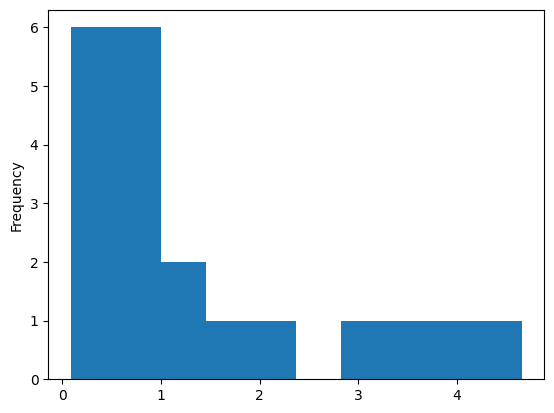

In [13]:
df["ts_diff_min"].plot(kind='hist')

<Axes: xlabel='abs_elapsed_day'>

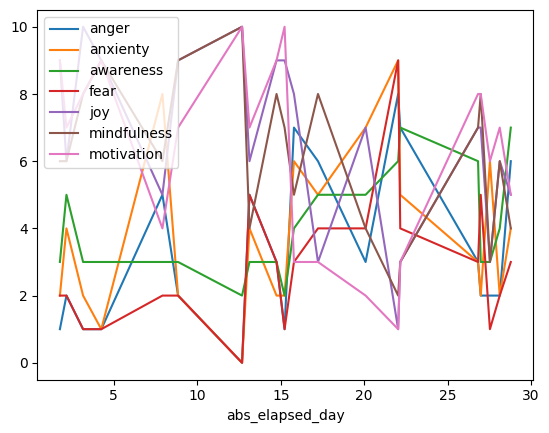

In [ ]:
df.plot(kind='line', x="abs_elapsed_day", y=["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"])

In [15]:
df[ctv].describe()

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
count,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.35000,3.80000,4.000000,2.850000,6.600000,6.150000,6.300000
std,2.41214,2.44088,1.555973,2.007224,2.623778,2.277464,2.773939
min,0.00000,0.00000,2.000000,0.000000,1.000000,2.000000,1.000000
25%,1.75000,2.00000,3.000000,1.750000,5.000000,4.000000,3.750000
50%,2.50000,3.50000,3.000000,2.500000,7.000000,6.000000,7.000000
75%,5.25000,5.25000,5.000000,4.000000,9.000000,8.000000,8.250000
max,8.00000,9.00000,7.000000,9.000000,10.000000,10.000000,10.000000


In [ ]:
pd.concat([df[btv].mean(),df[btv].std()], axis=1).transpose()

,event_striking,event_social,event_mindfulness
0,0.500000,0.800000,0.800000
1,0.512989,0.410391,0.410391


<Axes: >

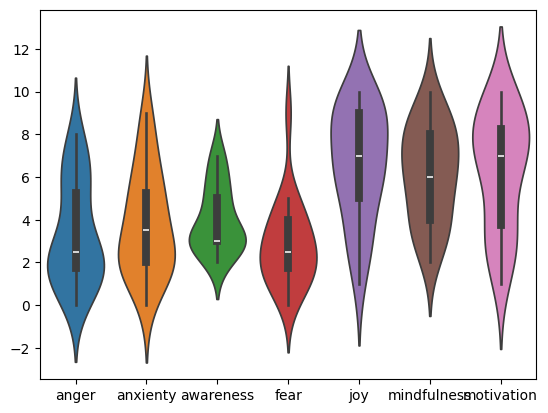

In [17]:
sns.violinplot(data=df[ctv])

In [18]:
def slide_mean(data : pd.DataFrame, headers, window_length = 3):
    part_df = df[headers]
    append = pd.concat([data[headers].mean() for x in range(0, window_length)], axis=1).transpose()
    ret = pd.concat([append, part_df, append]).reset_index()
    ret = ret.drop("index", axis=1)
    res = pd.DataFrame()
    for i in range(0, ret.shape[0] - window_length + 1):
        res = pd.concat([res, ret[i:i + window_length].mean()], axis=1)
    res = res.transpose().reset_index()
    res = res.drop("index", axis=1)
    return res

<Axes: >

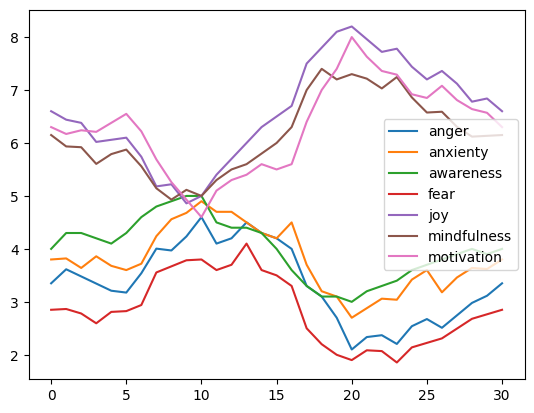

In [19]:
slide_df = slide_mean(df, ["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"], window_length=int(df.shape[0] / 2))
slide_df.plot(kind='line', y=["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"])

<Axes: >

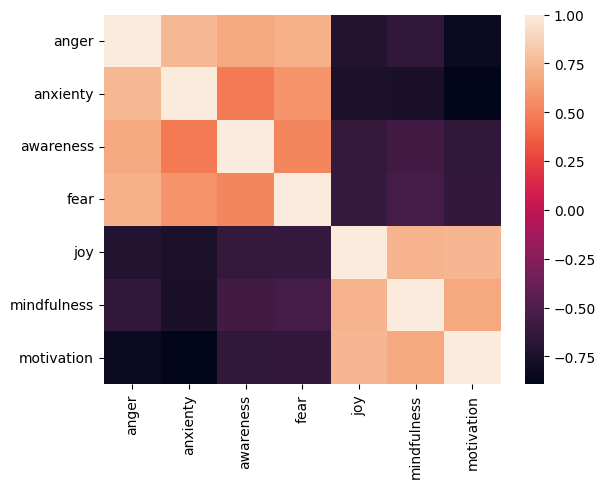

In [20]:
corr = df[ctv].corr()
sns.heatmap(corr)

In [21]:
corr

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
anger,1.000000,0.745527,0.673105,0.717994,-0.716843,-0.642379,-0.834569
anxienty,0.745527,1.000000,0.471169,0.584390,-0.752781,-0.761210,-0.892370
awareness,0.673105,0.471169,1.000000,0.522408,-0.631704,-0.564386,-0.646284
fear,0.717994,0.584390,0.522408,1.000000,-0.621604,-0.547456,-0.634273
joy,-0.716843,-0.752781,-0.631704,-0.621604,1.000000,0.724002,0.740495
mindfulness,-0.642379,-0.761210,-0.564386,-0.547456,0.724002,1.000000,0.675645
motivation,-0.834569,-0.892370,-0.646284,-0.634273,0.740495,0.675645,1.000000


Whereas 50% of submission record a striking event, almost 80% record social and mindfulness events. Considering class imbalance of *event_social* and *event_mindfulness* and lack of sufficient data, investigating distrubition patterns of these variables is ambigous. To compare samples factored by *event_striking*, means and standard deviations can be compared as below.

In [ ]:
pd.concat([df[df["event_striking"] == 1][ctv].mean(),df[df["event_striking"] == 0][ctv].mean()], axis=1).transpose()

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
0,3.3,4.4,3.9,2.9,6.0,6.1,6.0
1,3.4,3.2,4.1,2.8,7.2,6.2,6.6


In [ ]:
pd.concat([df[df["event_striking"] == 1][ctv].std(),df[df["event_striking"] == 0][ctv].std()], axis=1).transpose()

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
0,2.406011,3.025815,1.523884,2.514403,2.981424,2.469818,3.333333
1,2.547330,1.619328,1.663330,1.475730,2.201010,2.201010,2.221111


T-test will not be carried out as observing means and standard deviations seems sufficient to conclude there is no significant difference betweens samples factored by *event_striking*. For example, the difference of means between joy is 1.2 whereas the variations within the samples 2.98 and 2.2, thereby, no bimodal distrubitions are formed when sample distributions are considered due to high standard deviation.

# Anomaly Detection
## $\chi^2$ Test
$\sum_{1}^{n}Z^2=\chi^2$<br><br>
Summing over n many square of z-scores yield a chi-square distribution with n degrees of freedom. In our dataset, we have 7 continous variables that we can estimate z-scores, thus a $\chi^2$ test with 7 degrees of freedom is employed to see statistically significant submissions.

In [24]:
%%capture --no-stdout
ctvz = []
for ctd in ctv:
    df[f"{ctd}_z"] = df[ctd].apply(lambda x: (x-df[ctd].mean()) / df[ctd].std())
    ctvz.append(f"{ctd}_z")
df["stat_chi_7"] = df["anger_z"] ** 2 + df["anxienty_z"] ** 2 + df["awareness_z"] ** 2 + df["fear_z"] ** 2 + df["joy_z"] ** 2 + df["mindfulness_z"] ** 2 + df["motivation_z"] ** 2
df["p_chi_7"] = 1 - stats.chi2.cdf(df["stat_chi_7"], df=7)
anomaly = df[df["p_chi_7"] < (0.05 / df.shape[1])]
#anomaly['date'] = anomaly['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)))
df["is_chi_significant"] = df["p_chi_7"].apply(lambda x: True if x < 0.05 / df.shape[1] else False)

In [25]:
anomaly

,ts,anger,anxienty,awareness,fear,joy,mindfulness,motivation,event_striking,event_social,...,date,anger_z,anxienty_z,awareness_z,fear_z,joy_z,mindfulness_z,motivation_z,stat_chi_7,p_chi_7
6,1734694320.806405,8,9,6,9,1,2,1,1,0,...,2024-12-20,1.927749,2.130379,1.285369,3.063933,-2.134327,-1.822202,-1.910641,30.820912,0.000067


<Axes: >

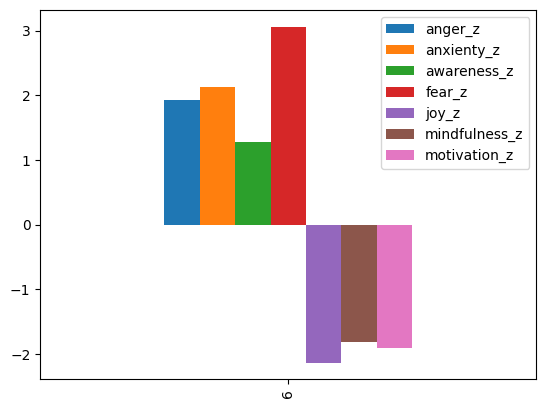

In [ ]:
anomaly[ctvz].plot(kind='bar')

In [27]:
df["is_chi_significant"] = df["p_chi_7"].apply(lambda x: True if x < 0.05 / df.shape[1] else False)

<Axes: ylabel='Frequency'>

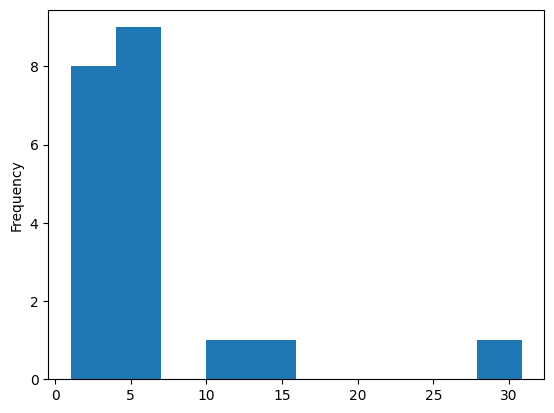

In [ ]:
df["stat_chi_7"].plot(kind='hist')

## Principal Component Analysis (PCA)

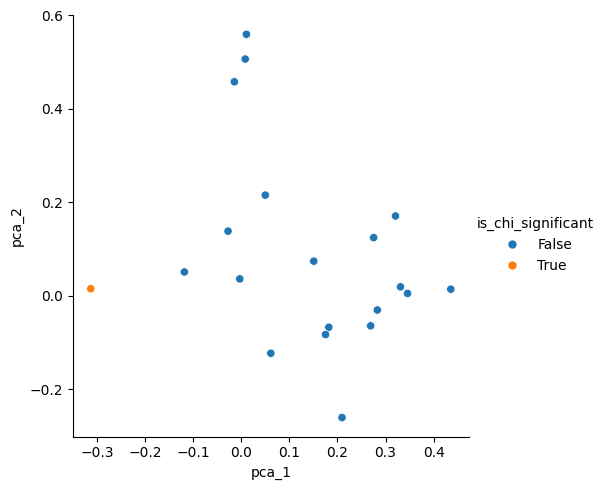

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df[ctv].transpose())
pc =  pd.DataFrame(pca.components_).transpose()
pc.columns = ["pca_1", "pca_2"]
df = pd.concat([df, pc], axis=1)
sns.relplot(data=df, x="pca_1", y="pca_2", hue="is_chi_significant")

In [30]:
df[df["pca_2"] > 0.4][ctv]

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
7,3,7,5,4,7,4,2
9,7,6,4,3,8,5,3
15,5,8,3,2,5,6,4


In [ ]:
df[df["pca_2"] > 0.4][ctvz]

,anger_z,anxienty_z,awareness_z,fear_z,joy_z,mindfulness_z,motivation_z
7,-0.145099,1.311003,0.642685,0.572931,0.152452,-0.944033,-1.550142
9,1.513179,0.901314,0.000000,0.074730,0.533582,-0.504948,-1.189644
15,0.684040,1.720691,-0.642685,-0.423470,-0.609808,-0.065863,-0.829146


<Axes: >

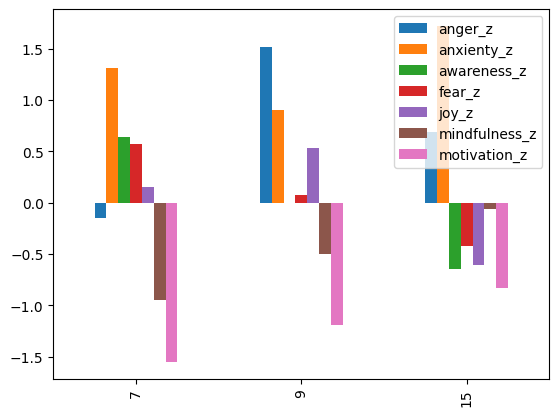

In [ ]:
df[df["pca_2"] > 0.4][ctvz].plot(kind='bar')

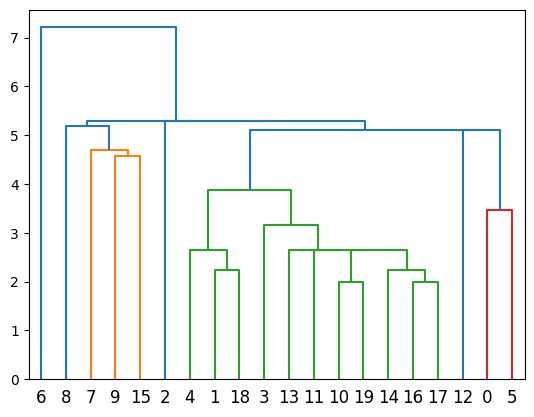

In [33]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(df[ctv], 'single')
dn = hierarchy.dendrogram(Z)


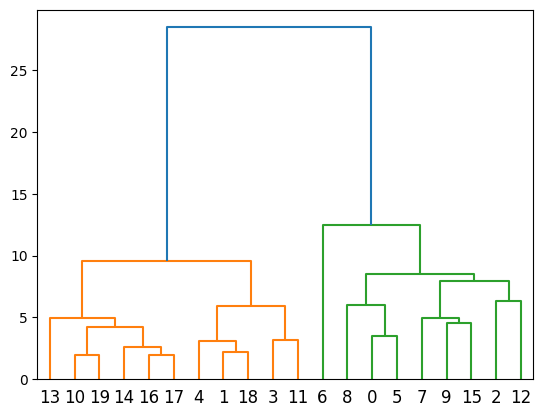

In [34]:
Z = hierarchy.linkage(df[ctv], 'ward')
dn = hierarchy.dendrogram(Z)

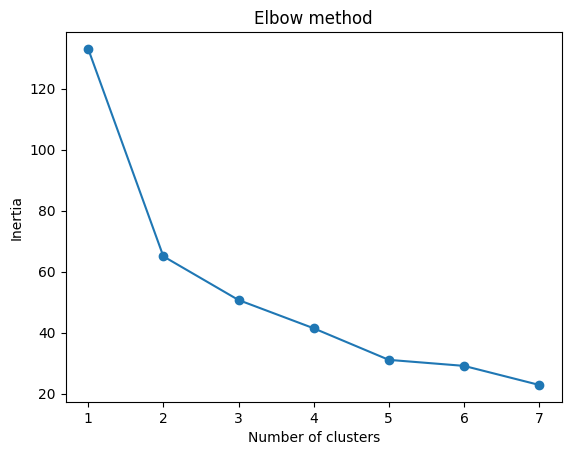

In [35]:
from sklearn.cluster import KMeans
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[ctvz])
    inertias.append(kmeans.inertia_)

plt.plot(range(1,8), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

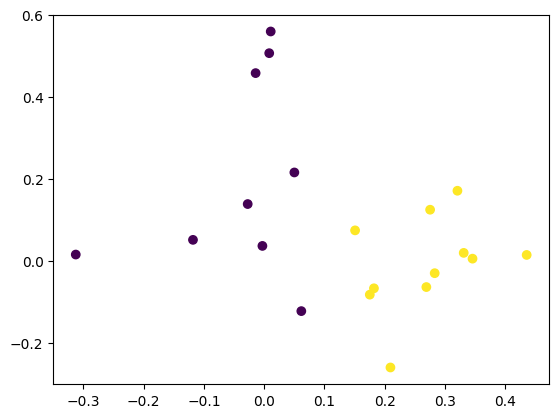

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[ctv])
plt.scatter(df["pca_1"], df["pca_2"], c=kmeans.labels_)
plt.show()

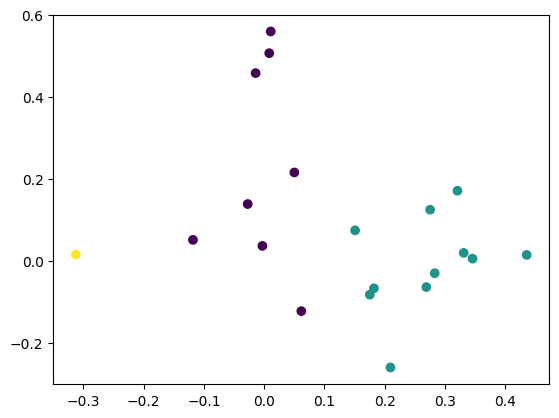

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[ctv])
plt.scatter(df["pca_1"], df["pca_2"], c=kmeans.labels_)
plt.show()